In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from datetime import date

In [3]:
import warnings
warnings.filterwarnings(action="ignore")

In [4]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [5]:
test_id = test.index
test_id[:20]

RangeIndex(start=0, stop=20, step=1)

In [6]:
df=pd.concat([train, test], axis=0, ignore_index=True)

In [7]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [8]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [9]:
df.shape

(2919, 81)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [11]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(col, "\t" , df[col].dtype, "\t" , df[col].isnull().sum())

MSZoning 	 object 	 4
LotFrontage 	 float64 	 486
Alley 	 object 	 2721
Utilities 	 object 	 2
Exterior1st 	 object 	 1
Exterior2nd 	 object 	 1
MasVnrType 	 object 	 1766
MasVnrArea 	 float64 	 23
BsmtQual 	 object 	 81
BsmtCond 	 object 	 82
BsmtExposure 	 object 	 82
BsmtFinType1 	 object 	 79
BsmtFinSF1 	 float64 	 1
BsmtFinType2 	 object 	 80
BsmtFinSF2 	 float64 	 1
BsmtUnfSF 	 float64 	 1
TotalBsmtSF 	 float64 	 1
Electrical 	 object 	 1
BsmtFullBath 	 float64 	 2
BsmtHalfBath 	 float64 	 2
KitchenQual 	 object 	 1
Functional 	 object 	 2
FireplaceQu 	 object 	 1420
GarageType 	 object 	 157
GarageYrBlt 	 float64 	 159
GarageFinish 	 object 	 159
GarageCars 	 float64 	 1
GarageArea 	 float64 	 1
GarageQual 	 object 	 159
GarageCond 	 object 	 159
PoolQC 	 object 	 2909
Fence 	 object 	 2348
MiscFeature 	 object 	 2814
SaleType 	 object 	 1
SalePrice 	 float64 	 1459


In [12]:
knn_imputer = KNNImputer(n_neighbors=5)  

In [13]:
for col in df._get_numeric_data().columns:
    if col!='SalePrice':
        df[col] = knn_imputer.fit_transform(df[col].values.reshape(-1, 1))
        
for col in df.select_dtypes(include=['O']):
    df[col].fillna(df[col].mode()[0], inplace=True)

In [14]:
df.isnull().sum().sort_values()

Id                 0
FireplaceQu        0
Fireplaces         0
Functional         0
TotRmsAbvGrd       0
                ... 
Exterior1st        0
RoofMatl           0
RoofStyle          0
Heating            0
SalePrice       1459
Length: 81, dtype: int64

In [15]:
df = df.drop('Id', axis=1)

In [16]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,RL,65.0,8450.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0.0,Ex,MnPrv,Shed,0.0,2.0,2008.0,WD,Normal,208500.0
1,20.0,RL,80.0,9600.0,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,0.0,Ex,MnPrv,Shed,0.0,5.0,2007.0,WD,Normal,181500.0
2,60.0,RL,68.0,11250.0,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0.0,Ex,MnPrv,Shed,0.0,9.0,2008.0,WD,Normal,223500.0
3,70.0,RL,60.0,9550.0,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0.0,Ex,MnPrv,Shed,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,60.0,RL,84.0,14260.0,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,0.0,Ex,MnPrv,Shed,0.0,12.0,2008.0,WD,Normal,250000.0


In [17]:
def transform_dataframe():
    # Copy the input DataFrame to avoid modifying the original

    # Mapping dictionary for quality-related columns
    qual_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No': 0}

    # Mapping for 'Fence'
    df['Fence'] = df['Fence'].map({'No': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4})

    # Mapping for quality-related columns
    quality_columns = ['PoolQC', 'HeatingQC', 'KitchenQual', 'ExterQual', 'ExterCond', 'BsmtQual',
                       'GarageQual', 'GarageCond', 'FireplaceQu']
    for col in quality_columns:
        df[col] = df[col].map(qual_dict)

    # Mapping for 'BsmtFinType2'
    BsmtFinType_dict = {'Unf': 1, 'No': 0, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    df['BsmtFinType2'] = df['BsmtFinType2'].map(BsmtFinType_dict)

    # Mapping for 'BsmtExposure'
    df['BsmtExposure'] = df['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 0})

    # Feature engineering
    df['TotalSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Total_porch_sf'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
    df['GrDividedLotArea'] = df['GrLivArea'] / df['LotArea']
    df['KitchenBedroomAbvGr'] = df['KitchenAbvGr'] + df['BedroomAbvGr']
    todays_date = date.today()
    df["Building_age"] = todays_date.year - df["YearBuilt"].astype('int')
    df['Sold_GarageYrBlt'] = df['YrSold'].astype(int) - df['GarageYrBlt'].astype('float')
    df['Sold_GarageYrBlt'] = df['Sold_GarageYrBlt'].astype(str)
    df['Sold_Built'] = df['YrSold'].astype(int) - df['YearBuilt'].astype(int)
    df['Sold_Built'] = df['Sold_Built'].astype(str)
    df['Sold_RemodAdd'] = df['YrSold'].astype(int) - df['YearRemodAdd'].astype('float')
    df['Sold_RemodAdd'] = df['Sold_RemodAdd'].astype('str')
    df["HighQualSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    df["SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] +
                                           df["FullBath"] +
                                           df["HalfBath"] +
                                           df["KitchenAbvGr"])

    # Binary features
    df['HasTotalBsmtSF'] = [0 if i == 0 else 1 for i in df['TotalBsmtSF'].astype(int)]
    df['Has2ndFlrSF'] = [0 if i == 0 else 1 for i in df['2ndFlrSF'].astype(int)]
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['Has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['Hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    return df

In [18]:
transformed_df = transform_dataframe()

In [19]:
transformed_df.isnull().sum().sort_values()

MSSubClass          0
ScreenPorch         0
3SsnPorch           0
EnclosedPorch       0
OpenPorchSF         0
                 ... 
ExterQual           0
MasVnrArea          0
BsmtFinType2        0
Hasfireplace        0
SalePrice        1459
Length: 97, dtype: int64

In [20]:
transformed_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Sold_RemodAdd,HighQualSF,SqFtPerRoom,HasTotalBsmtSF,Has2ndFlrSF,HasPool,Has2ndfloor,HasGarage,HasBsmt,Hasfireplace
0,60.0,RL,65.0,8450.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,5.0,1710.0,142.500000,1,1,0,1,1,1,0
1,20.0,RL,80.0,9600.0,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,31.0,1262.0,140.222222,1,0,0,0,1,1,1
2,60.0,RL,68.0,11250.0,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,6.0,1786.0,178.600000,1,1,0,1,1,1,1
3,70.0,RL,60.0,9550.0,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,36.0,1717.0,190.777778,1,1,0,1,1,1,1
4,60.0,RL,84.0,14260.0,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,8.0,2198.0,169.076923,1,1,0,1,1,1,1


In [21]:
df = pd.get_dummies(transformed_df, drop_first=True)

In [22]:
train=df[df['SalePrice'].notnull()]
test=df[df['SalePrice'].isnull()].drop('SalePrice', axis=1)

In [23]:
from sklearn.feature_selection import mutual_info_regression

def add_random_column_and_select_features(train, target_col='target'):
    random_col = 'Random_Column'
    df = train.copy()
    df[random_col] = np.random.rand(len(df))

    mi_scores = pd.Series(index=df.columns, dtype=float)
    for col in df.columns:
        if col != target_col:
            mi_scores[col] = mutual_info_regression(df[[col]], df[target_col])

    print("Mutual Information Scores:")
    print(mi_scores)

    less_important_cols = mi_scores[mi_scores < mi_scores[random_col]].index

    return less_important_cols

In [24]:
less_important_cols = add_random_column_and_select_features(train, target_col='SalePrice')

Mutual Information Scores:
MSSubClass            0.278166
LotFrontage           0.221297
LotArea               0.160524
OverallQual           0.565510
OverallCond           0.110764
                        ...   
Sold_RemodAdd_60.0    0.006135
Sold_RemodAdd_7.0     0.016385
Sold_RemodAdd_8.0     0.014503
Sold_RemodAdd_9.0     0.006012
Random_Column         0.000000
Length: 534, dtype: float64


In [25]:
train = train.drop(columns = less_important_cols)
test = test.drop(columns = less_important_cols)

In [26]:
num_cols=list(train._get_numeric_data().columns)

In [27]:
num_cols.remove("SalePrice")

In [28]:
X = train.drop(["SalePrice"], axis=1)
y = df[['SalePrice']]

In [29]:
scaler = StandardScaler()

scaler.fit(X[num_cols])

X[num_cols]=scaler.transform(X[num_cols])

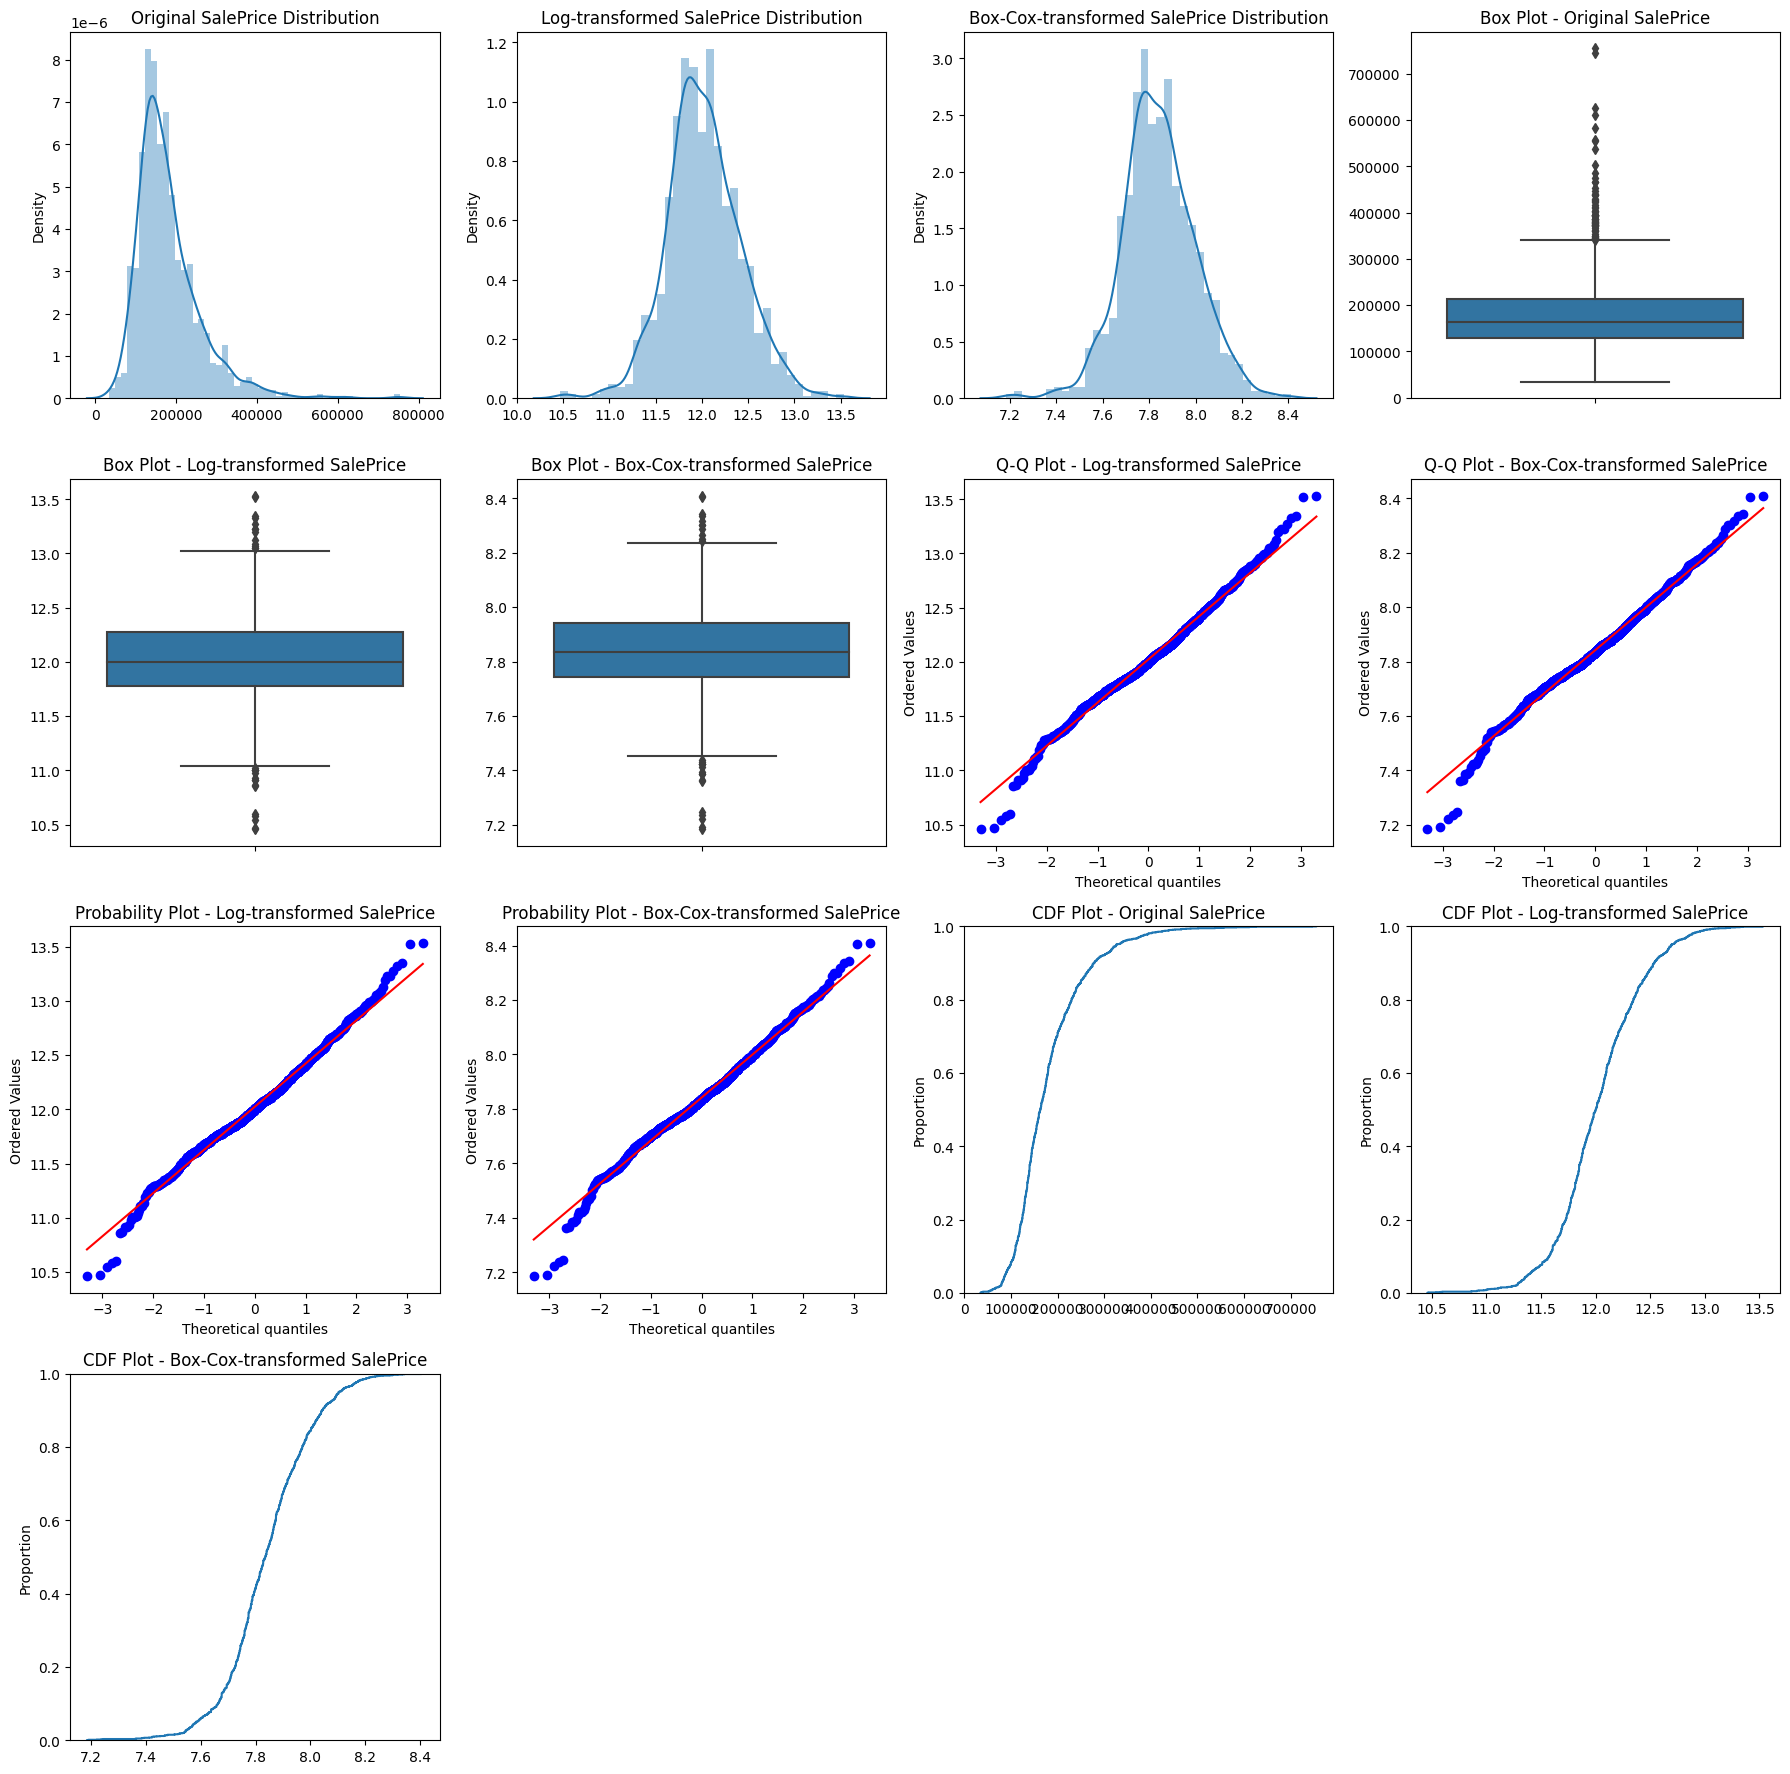

In [30]:
sale_price = train['SalePrice'].values
sale_price_log = np.log1p(sale_price)
sale_price_boxcox, _ = stats.boxcox(sale_price + 1)

plt.figure(figsize=(18, 18))

# Original SalePrice Distribution
plt.subplot(4, 4, 1)
sns.distplot(sale_price, kde=True, hist=True)
plt.title('Original SalePrice Distribution')

# Log-transformed SalePrice Distribution
plt.subplot(4, 4, 2)
sns.distplot(sale_price_log, kde=True, hist=True)
plt.title('Log-transformed SalePrice Distribution')

# Box-Cox-transformed SalePrice Distribution
plt.subplot(4, 4, 3)
sns.distplot(sale_price_boxcox, kde=True, hist=True)
plt.title('Box-Cox-transformed SalePrice Distribution')

# Box Plot for Original SalePrice
plt.subplot(4, 4, 4)
sns.boxplot(y=sale_price)
plt.title('Box Plot - Original SalePrice')

# Box Plot for Log-transformed SalePrice
plt.subplot(4, 4, 5)
sns.boxplot(y=sale_price_log)
plt.title('Box Plot - Log-transformed SalePrice')

# Box Plot for Box-Cox-transformed SalePrice
plt.subplot(4, 4, 6)
sns.boxplot(y=sale_price_boxcox)
plt.title('Box Plot - Box-Cox-transformed SalePrice')

# Q-Q Plot for Log-transformed SalePrice
plt.subplot(4, 4, 7)
stats.probplot(sale_price_log, plot=plt)
plt.title('Q-Q Plot - Log-transformed SalePrice')

# Q-Q Plot for Box-Cox-transformed SalePrice
plt.subplot(4, 4, 8)
stats.probplot(sale_price_boxcox, plot=plt)
plt.title('Q-Q Plot - Box-Cox-transformed SalePrice')

# Probability Plot for Log-transformed SalePrice
plt.subplot(4, 4, 9)
stats.probplot(sale_price_log, dist='norm', plot=plt)
plt.title('Probability Plot - Log-transformed SalePrice')

# Probability Plot for Box-Cox-transformed SalePrice
plt.subplot(4, 4, 10)
stats.probplot(sale_price_boxcox, dist='norm', plot=plt)
plt.title('Probability Plot - Box-Cox-transformed SalePrice')

# CDF Plot for Original SalePrice
plt.subplot(4, 4, 11)
sns.ecdfplot(sale_price)
plt.title('CDF Plot - Original SalePrice')

# CDF Plot for Log-transformed SalePrice
plt.subplot(4, 4, 12)
sns.ecdfplot(sale_price_log)
plt.title('CDF Plot - Log-transformed SalePrice')

# CDF Plot for Box-Cox-transformed SalePrice
plt.subplot(4, 4, 13)
sns.ecdfplot(sale_price_boxcox)
plt.title('CDF Plot - Box-Cox-transformed SalePrice')

plt.tight_layout()
plt.show()

In [31]:
train['SalePrice'] = sale_price_log

In [32]:
print("Skewness coeff. is: %f" % train[train['SalePrice'].notnull()]['SalePrice'].skew())
print("Kurtosis coeff. is: %f" % train[train['SalePrice'].notnull()]['SalePrice'].kurt())

Skewness coeff. is: 0.121347
Kurtosis coeff. is: 0.809519


In [33]:
y = sale_price_log

In [34]:
def run_regression_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(),
        'Ridge': Ridge(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'Support Vector Regression': SVR()
    }


    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        print(f"{model_name} Root Mean Squared Error: {math.sqrt(mse)}")

        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        print(f"{model_name} Cross-Validation Root Mean Squared Error: {math.sqrt(np.mean(-cv_scores))}")

        print("="*40)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [36]:
run_regression_models(X_train, y_train, X_test, y_test)

Training Linear Regression...
Linear Regression Root Mean Squared Error: 373984503527.7098
Linear Regression Cross-Validation Root Mean Squared Error: 36813862457.65313
Training Lasso...
Lasso Root Mean Squared Error: 0.43324391618066094
Lasso Cross-Validation Root Mean Squared Error: 0.390941443386101
Training Ridge...
Ridge Root Mean Squared Error: 0.2013645654425653
Ridge Cross-Validation Root Mean Squared Error: 0.22373661525181093
Training Decision Tree...
Decision Tree Root Mean Squared Error: 0.18401439792980423
Decision Tree Cross-Validation Root Mean Squared Error: 0.20870945416207834
Training Random Forest...
Random Forest Root Mean Squared Error: 0.1481104691107285
Random Forest Cross-Validation Root Mean Squared Error: 0.1476484540259051
Training Support Vector Regression...
Support Vector Regression Root Mean Squared Error: 0.2081294868058546
Support Vector Regression Cross-Validation Root Mean Squared Error: 0.18826632996866252


In [37]:
def submission(test_id, predict):
    res=pd.DataFrame()
    res['SalePrice']=np.around(predict, 2)
    res['Id']=test_id
    return res[['Id', 'SalePrice']]

In [38]:
model= RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

In [39]:
pre=model.predict(test)
res=submission(test_id, pre)
res['SalePrice']=np.exp(res['SalePrice'])
res.to_csv('submission.csv', index=False)

<a href="submission.csv"> Download File </a>